#                             Energy price forecasting using LSTM 

In [82]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from io import StringIO
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers

## Data visualization

#### Import data

In [11]:
data=pd.read_csv('C:\\Users\\AlkiS-HoMe\\Desktop\\priceWeatherEnergy.csv',dtype={'prediction_date':'category'}, index_col='prediction_date')
data.index.name = 'prediction_date'
# mark all NA values with 0
data.fillna(0, inplace=True)
data.head()


,Price,wind_direction_100m,temperature,air_density,pressure,precipitation,wind_gust,radiation,wind_speed,wind_direction,...,reservoirs,run-of-river,imports,exports,ssg_hydro,ssg_thermal,ssg_wind,ssg_photovoltaic,ssg_wave,pumping
prediction_date,,,,,,,,,,,,,,,,,,,,,
1/1/2015 01:00,47.33,37.733333,3.466667,1.253333,997.000000,0.0,3.300000,0.0,2.633333,37.433333,...,3773.8,2773.5,107.5,0.0,224.7,2418.7,1549.6,0.0,0.0,0.0
1/1/2015 02:00,42.27,38.466667,3.400000,1.253333,996.800000,0.0,3.400000,0.0,2.700000,38.533333,...,3731.3,2321.5,2127.9,0.0,285.5,3172.4,2172.4,0.0,0.0,0.0
1/1/2015 03:00,38.41,39.233333,3.400000,1.253333,996.566667,0.0,3.500000,0.0,2.800000,39.633333,...,1879.8,1467.1,3654.3,0.0,269.7,3210.9,2338.0,0.0,0.0,321.9
1/1/2015 04:00,35.72,43.533333,3.366667,1.253333,996.633333,0.0,3.566667,0.0,2.833333,44.166667,...,898.2,1268.1,3987.2,0.0,286.5,3205.2,2736.5,0.0,0.0,1279.8
1/1/2015 05:00,35.13,47.866667,3.366667,1.256667,996.733333,0.0,3.566667,0.0,2.900000,48.666667,...,607.3,1329.9,4253.7,0.0,311.5,3215.2,2899.6,0.0,0.0,2457.9


#### Price data

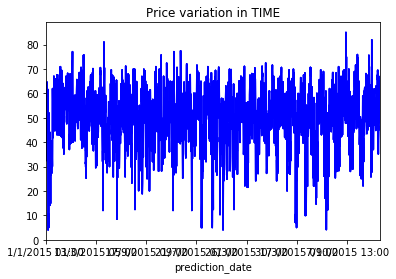

prediction_date
1/1/2015 01:00    47.33
1/1/2015 02:00    42.27
1/1/2015 03:00    38.41
1/1/2015 04:00    35.72
1/1/2015 05:00    35.13
Name: Price, dtype: float64

Dimensions of the price table is: (6659,)


In [14]:
price=data["Price"]
price.plot(c="b", title="Price variation in TIME")
pyplot.show()
print(price.head(5))
print("\nDimensions of the price table is:", price.shape)

#### Weather and Energy data

C:\ProgramData\Anaconda3\envs\TensorFlow2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


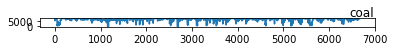

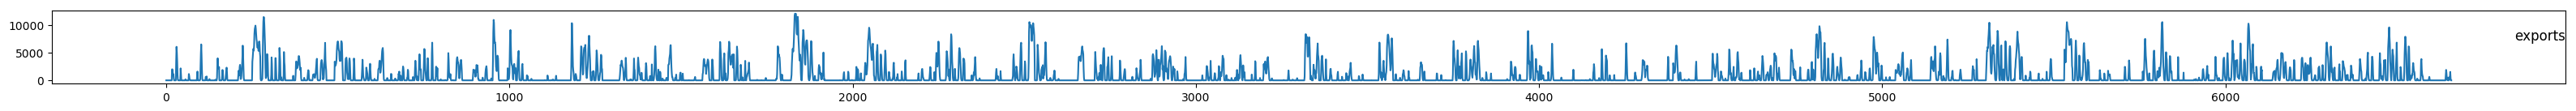

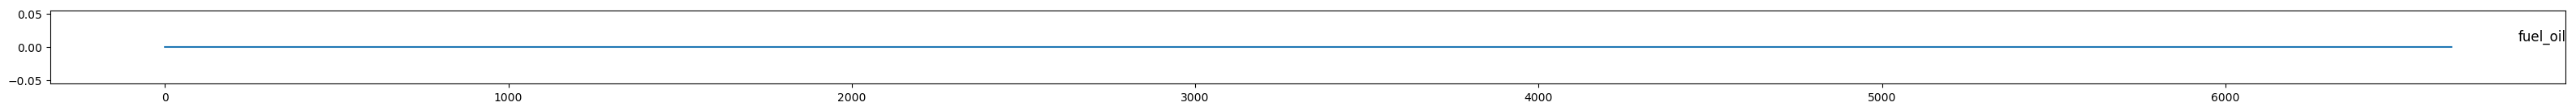

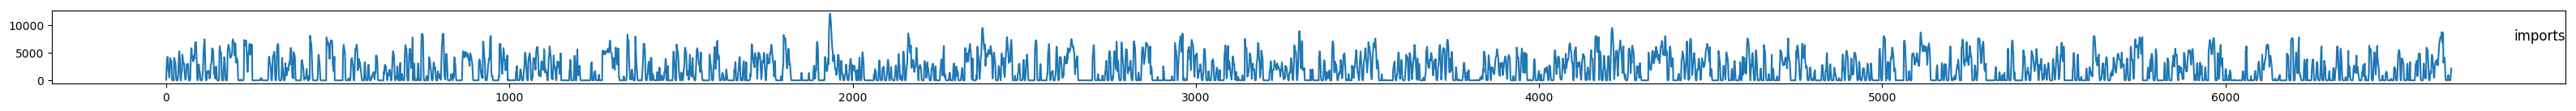

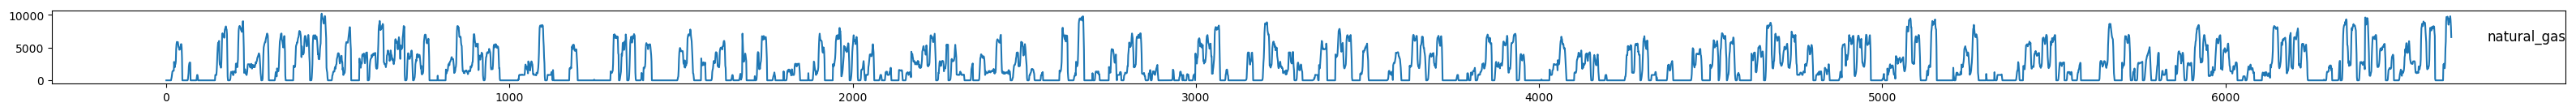

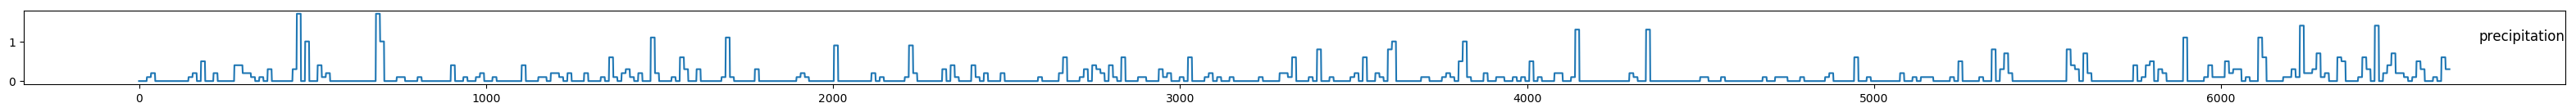

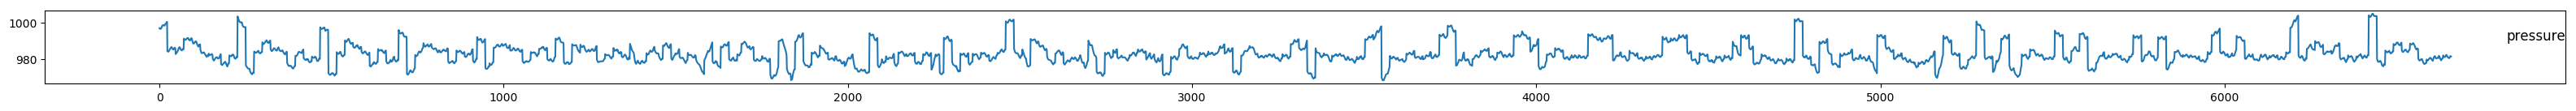

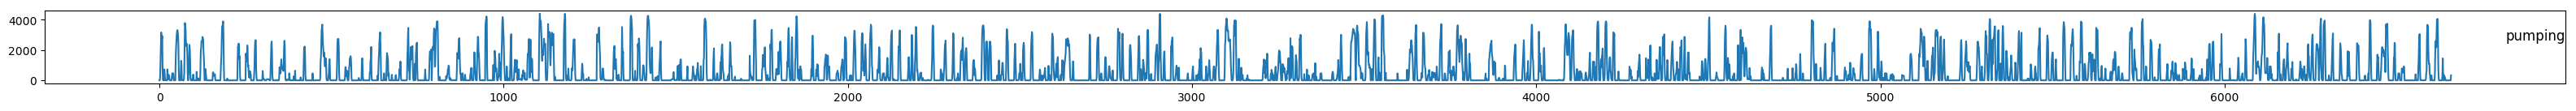

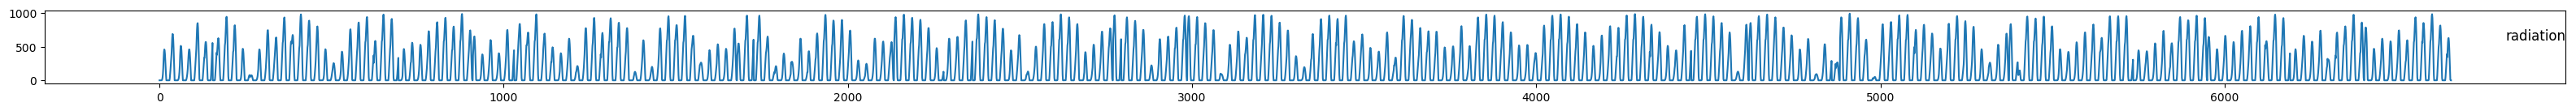

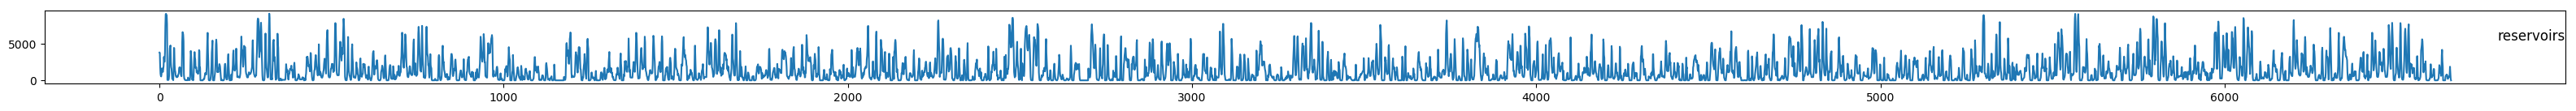

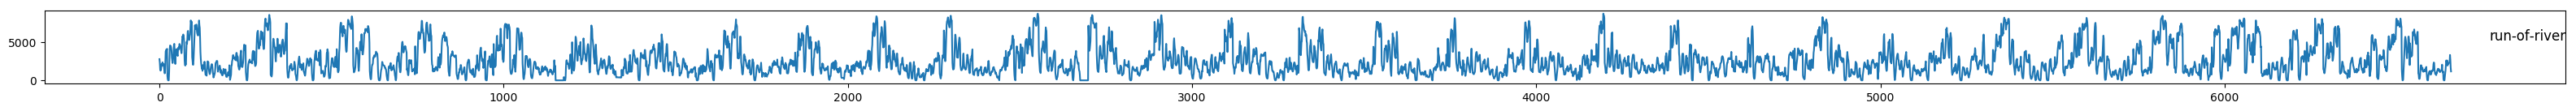

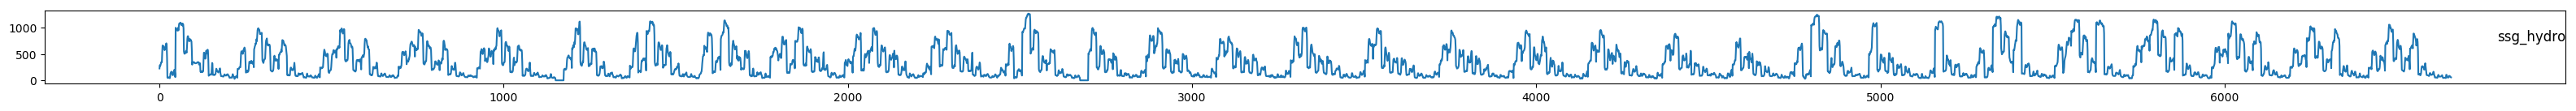

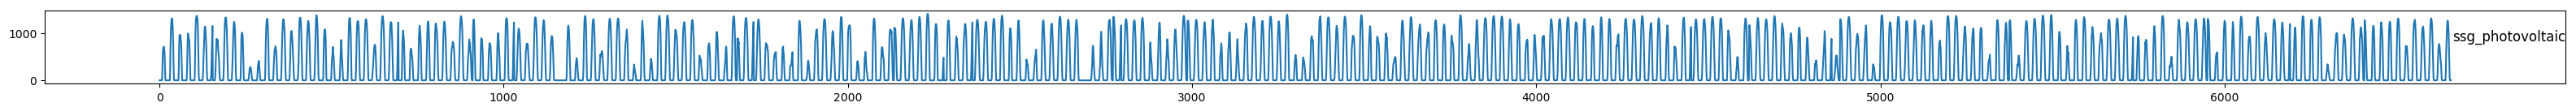

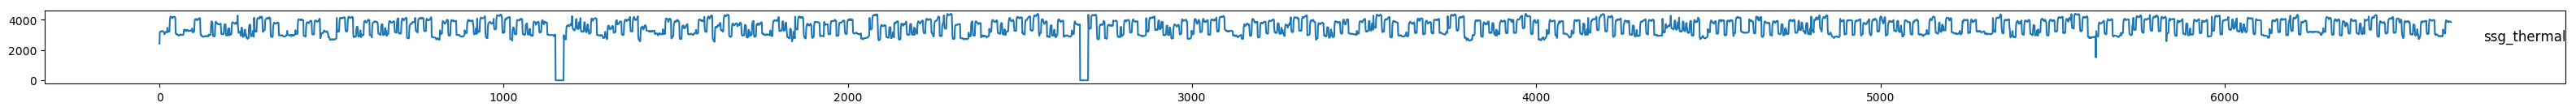

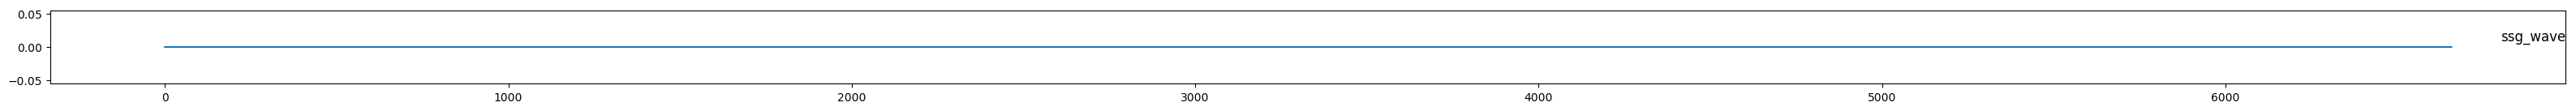

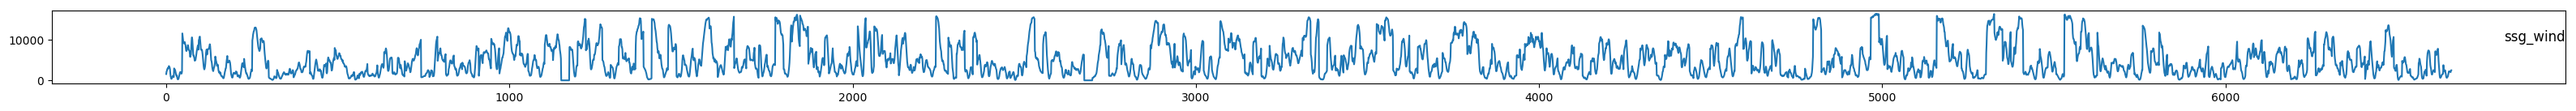

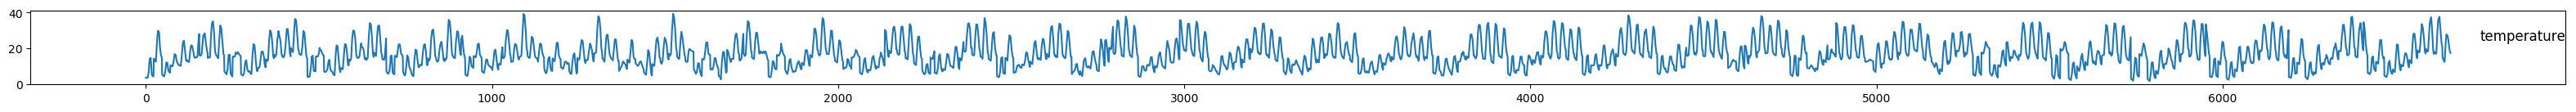

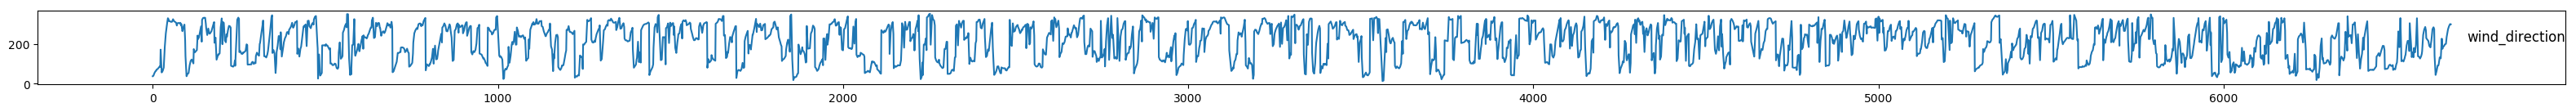

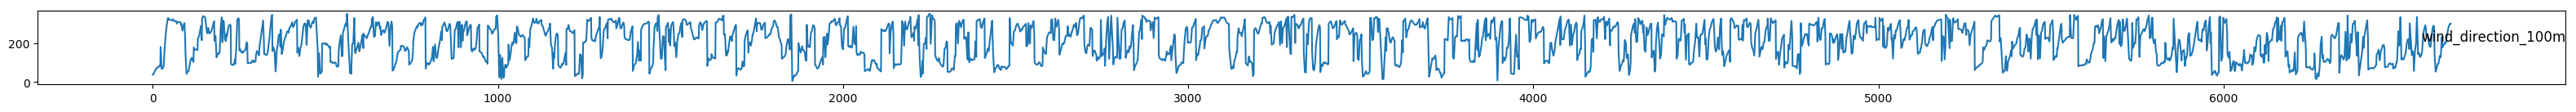

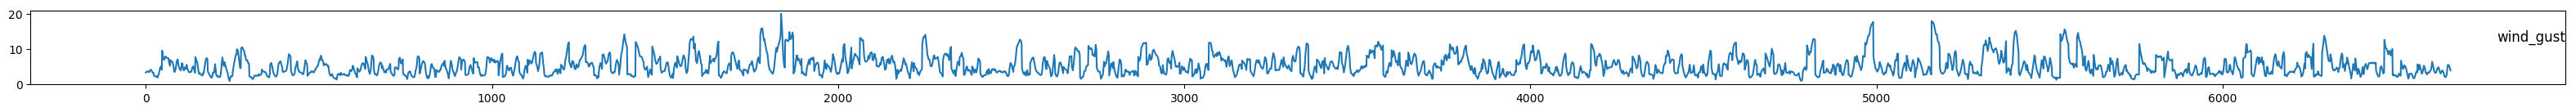

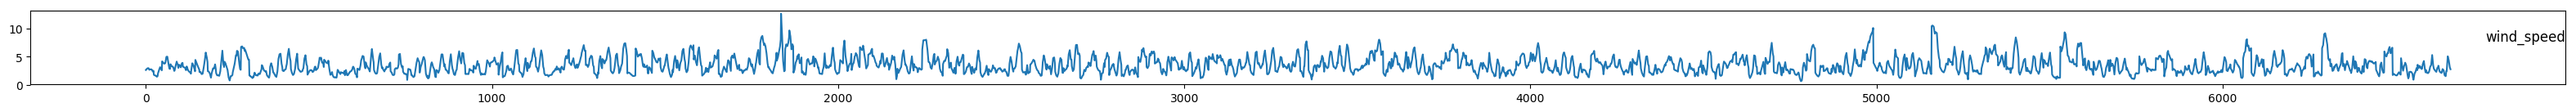

AttributeError: 'function' object has no attribute 'savefig'

In [54]:
weatherEnergy=data[data.columns.difference(['Price'])]
values = weatherEnergy.values

# specify columns to plot
groups = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(weatherEnergy.columns[group], y=0.5, loc='right')
    i += 1
    pyplot.figure(figsize=(40, 30), dpi= 100, facecolor='w', edgecolor='k')
pyplot.show()


### Convert a Time Series to a Supervised Learning Problem in Python 

##### The below function was retrieved from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [55]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

values=data.values
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (only weather data for time t)
reframed.drop(reframed.columns[24:46], axis=1, inplace=True)

print(reframed.head())
print("\nDimensions of the price table is:", reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.534608   0.094152   0.050265       0.96   0.781702        0.0   
2   0.472178   0.096251   0.048501       0.96   0.776266        0.0   
3   0.424553   0.098445   0.048501       0.96   0.769926        0.0   
4   0.391363   0.110751   0.047619       0.96   0.771740        0.0   
5   0.384084   0.123152   0.047619       0.98   0.774456        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var15(t-1)  \
1   0.127178        0.0   0.164345    0.071863    ...       0.317901   
2   0.132404        0.0   0.169916    0.075103    ...       0.266093   
3   0.137631        0.0   0.178273    0.078343    ...       0.168161   
4   0.141115        0.0   0.181058    0.091694    ...       0.145351   
5   0.141115        0.0   0.186630    0.104948    ...       0.152435   

   var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  var21(t-1)  \
1    0.008890         0.0    0.178008    0.550192    0.094351  

### Split in Test and Train data

In [56]:
# split into train and test sets
values = reframed.values
n_train_hours = 4500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


## Fit an LSTM on the multivariate input data

In [57]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4500, 1, 23) (4500,) (2158, 1, 23) (2158,)


In [58]:
# all data should be in numpy array form
train_X=np.array(train_X)
test_X=np.array(test_X)
train_y=np.array(train_y)
test_y=np.array(test_y)

Train on 4500 samples, validate on 2158 samples
Epoch 1/100
1s - loss: 0.2197 - val_loss: 0.1150
Epoch 2/100
0s - loss: 0.0999 - val_loss: 0.0871
Epoch 3/100
0s - loss: 0.0832 - val_loss: 0.0764
Epoch 4/100
0s - loss: 0.0751 - val_loss: 0.0711
Epoch 5/100
0s - loss: 0.0705 - val_loss: 0.0669
Epoch 6/100
0s - loss: 0.0664 - val_loss: 0.0622
Epoch 7/100
0s - loss: 0.0622 - val_loss: 0.0580
Epoch 8/100
0s - loss: 0.0578 - val_loss: 0.0534
Epoch 9/100
0s - loss: 0.0532 - val_loss: 0.0503
Epoch 10/100
0s - loss: 0.0485 - val_loss: 0.0461
Epoch 11/100
0s - loss: 0.0443 - val_loss: 0.0416
Epoch 12/100
0s - loss: 0.0403 - val_loss: 0.0384
Epoch 13/100
0s - loss: 0.0373 - val_loss: 0.0368
Epoch 14/100
0s - loss: 0.0361 - val_loss: 0.0358
Epoch 15/100
0s - loss: 0.0356 - val_loss: 0.0357
Epoch 16/100
0s - loss: 0.0354 - val_loss: 0.0353
Epoch 17/100
0s - loss: 0.0351 - val_loss: 0.0349
Epoch 18/100
0s - loss: 0.0350 - val_loss: 0.0348
Epoch 19/100
0s - loss: 0.0349 - val_loss: 0.0348
Epoch 20/10

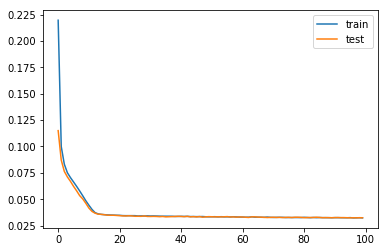

In [99]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# change learning rate of the optimizer
# adam=optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate Model

In [100]:
# make a prediction
yhat = model.predict(test_X)
test__X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test__X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test__y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test__y, test__X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



Test RMSE: 4.286
